In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [2]:
# Cargar datasets
products = pd.read_csv('../data/raw/olist_products_dataset.csv')
categories = pd.read_csv('../data/raw/product_category_name_translation.csv') 
items = pd.read_csv('../data/raw/olist_order_items_dataset.csv')
reviews = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv')

In [3]:
# Traducir nombres de categorías
products = products.merge(categories, on='product_category_name', how='left')

# Promedio de review por producto
avg_reviews = reviews.groupby('order_id')['review_score'].mean().reset_index()
items = items.merge(avg_reviews, on='order_id', how='left')

# Promedio de review por producto_id
product_reviews = items.groupby('product_id')['review_score'].mean().reset_index()
product_reviews.columns = ['product_id', 'avg_review_score']

# Unir reviews con productos
data = products.merge(product_reviews, on='product_id', how='left')

# Reemplazar NaN por valores neutros (versión segura sin warnings)
data['avg_review_score'] = data['avg_review_score'].fillna(3)
data['product_category_name_english'] = data['product_category_name_english'].fillna('Unknown')

data.head()


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,avg_review_score
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,5.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,5.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,5.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,1.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,5.0


In [4]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_name_lenght            32341 non-null  float64
 3   product_description_lenght     32341 non-null  float64
 4   product_photos_qty             32341 non-null  float64
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32951 non-null  object 
 10  avg_review_score               32951 non-null  float64
dtypes: float64(8), object(3)
memory usage: 2.8+ MB


product_id                         0
product_category_name            610
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english      0
avg_review_score                   0
dtype: int64

In [5]:
# Rellenar nulos en columnas numéricas con la mediana
num_cols = [
    'product_name_lenght', 
    'product_description_lenght', 
    'product_photos_qty',
    'product_weight_g', 
    'product_length_cm', 
    'product_height_cm', 
    'product_width_cm'
]

for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

# Verificación final
print(data.isnull().sum())


product_id                         0
product_category_name            610
product_name_lenght                0
product_description_lenght         0
product_photos_qty                 0
product_weight_g                   0
product_length_cm                  0
product_height_cm                  0
product_width_cm                   0
product_category_name_english      0
avg_review_score                   0
dtype: int64


In [6]:
# Selección de columnas
num_features = ['avg_review_score', 'product_weight_g', 'product_length_cm',
                'product_height_cm', 'product_width_cm', 'product_photos_qty']
cat_features = ['product_category_name_english']

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
cat_encoded = encoder.fit_transform(data[cat_features])

# Escalado
scaler = StandardScaler()
num_scaled = scaler.fit_transform(data[num_features])

X = np.hstack([num_scaled, cat_encoded])

In [7]:
inertias = []
K = range(2, 12)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)


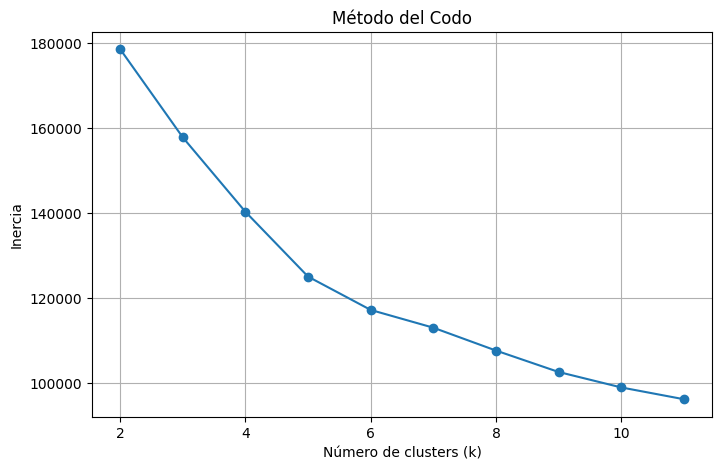

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

In [9]:
kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Ver los primeros productos con su cluster
print(data[['product_id', 'product_category_name_english', 'cluster']].head(15))

                          product_id product_category_name_english  cluster
0   1e9e8ef04dbcff4541ed26657ea517e5                     perfumery        2
1   3aa071139cb16b67ca9e5dea641aaa2f                           art        2
2   96bd76ec8810374ed1b65e291975717f                sports_leisure        2
3   cef67bcfe19066a932b7673e239eb23d                          baby        1
4   9dc1a7de274444849c219cff195d0b71                    housewares        3
5   41d3672d4792049fa1779bb35283ed13           musical_instruments        2
6   732bd381ad09e530fe0a5f457d81becb                    cool_stuff        4
7   2548af3e6e77a690cf3eb6368e9ab61e               furniture_decor        1
8   37cc742be07708b53a98702e77a21a02               home_appliances        1
9   8c92109888e8cdf9d66dc7e463025574                          toys        2
10  14aa47b7fe5c25522b47b4b29c98dcb9                bed_bath_table        2
11  03b63c5fc16691530586ae020c345514                          baby        0
12  cf55509e

In [10]:
score = silhouette_score(X, data['cluster'])
print("Silhouette Score:", score)

Silhouette Score: 0.20532420330996545


In [11]:
cluster_summary = data.groupby('cluster')[num_features].mean()
print(cluster_summary)

print(data.groupby('cluster')['product_category_name_english'].agg(lambda x: x.value_counts().head(3)))


         avg_review_score  product_weight_g  product_length_cm  \
cluster                                                          
0                4.329310       2973.689677          50.094405   
1                1.941220       1091.951607          25.975236   
2                4.618037        760.863799          22.442991   
3                4.343424       1227.633840          26.360940   
4                3.821973      14930.333333          51.158520   

         product_height_cm  product_width_cm  product_photos_qty  
cluster                                                           
0                16.765800         35.312530            1.914578  
1                14.931002         20.041588            1.689603  
2                13.749309         17.469355            1.505698  
3                14.725676         19.801139            5.468913  
4                47.014971         40.396742            2.175694  
cluster
0    [1431, 1069, 506]
1      [606, 439, 427]
2    [1706, 14

In [17]:

# Ejemplo con IDs reales
customer_products = data['product_id'].sample(1, random_state=42).tolist()
print("Productos del cliente:", customer_products)

# Obtener clusters de esos productos
clusters_bought = data[data['product_id'].isin(customer_products)]['cluster'].unique()
print("Clusters del cliente:", clusters_bought)

# Buscar productos del mismo cluster
recommended = data[(data['cluster'].isin(clusters_bought)) &
                   (~data['product_id'].isin(customer_products))]

print("Productos recomendados encontrados:", len(recommended))
print(recommended[['product_id', 'product_category_name_english', 'avg_review_score']].head(10))


Productos del cliente: ['f819f0c84a64f02d3a5606ca95edd272']
Clusters del cliente: [2]
Productos recomendados encontrados: 14830
                          product_id product_category_name_english  \
0   1e9e8ef04dbcff4541ed26657ea517e5                     perfumery   
1   3aa071139cb16b67ca9e5dea641aaa2f                           art   
2   96bd76ec8810374ed1b65e291975717f                sports_leisure   
5   41d3672d4792049fa1779bb35283ed13           musical_instruments   
9   8c92109888e8cdf9d66dc7e463025574                          toys   
10  14aa47b7fe5c25522b47b4b29c98dcb9                bed_bath_table   
12  cf55509ea8edaaac1d28fdb16e48fc22           musical_instruments   
15  3bb7f144022e6732727d8d838a7b13b3                sports_leisure   
16  6a2fb4dd53d2cdb88e0432f1284a004c                     perfumery   
17  a1b71017a84f92fd8da4aeefba108a24         computers_accessories   

    avg_review_score  
0                5.0  
1                5.0  
2                5.0  
5        